In [50]:
!pip install PyShp
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import *
from scipy.spatial import distance
import math
import shapefile as shp

In [52]:
desired_width = 320
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth=desired_width)
pd.set_option('display.max_columns', 12)


In [53]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords'
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    records = [y[:] for y in sf.records()]
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [54]:
GIS_data = pd.read_csv('csv_files/mean_car_count_per_grid.csv')
car_park_data = pd.read_csv('csv_files/council_car_parks_in_grid.csv')
existing_chg_data = pd.read_csv('csv_files/existing_ev_charging_locations_touching.csv')

In [59]:
car_park_data.head()

,fid,UPRN,Site Name,Address,Easting,Northing,Ward,Lease Information,Site Function,Sub Function,Function Detail
0,1,10091144641,"Car Park Bounded By Trinity Way, A6402 And The...","Car Park Bounded By Trinity Way, A6402, Rive...",382812,397838,Deansgate,Leasehold,Non-Operational,Investment,Car Parking
1,2,10091145877,Land For Car Park Potato Wharf,"Land For Car Park, Potato Wharf,",383017,397735,Deansgate,Leasehold,Non-Operational,Investment,Car Parking
2,3,10023047744,Car Parking Spaces Rear Of 17 Ellesmere Street,"Car Parking Spaces Rear Of 17, Ellesmere Stree...",382685,397193,Hulme,Leasehold,Non-Operational,Investment,Car Parking
3,4,10023051981,Castlefield Estates Ltd Car Park & Land under ...,Castlefield Estates Ltd Car Park & Land under ...,383140,397597,Deansgate,Leasehold,Non-Operational,Investment,Car Parking
4,5,10091145307,Land Rear Of 31 To 35 Bury New Road Cheetwood ...,"Land Rear Of 31 To 35 Bury New Road, Cheetwood...",383482,399640,Cheetham,Leasehold,Non-Operational,Investment,Car Parking


In [60]:
GIS_data.head()

,fid,left,top,right,bottom,cars_and_taxis_mean,spatial_mean,car_count_final,Area_of_cell,mixed_use_area_per_cell,landuse_simplified
0,1,382181.7767,402134.6219,382681.7767,401634.6219,NaN,0.000000,0.000000,250197.5868,0.000,NaN
1,2,382181.7767,401634.6219,382681.7767,401134.6219,NaN,0.000000,0.000000,250197.5867,0.000,NaN
2,3,382181.7767,401134.6219,382681.7767,400634.6219,NaN,0.000000,0.000000,250197.5868,46657.617,Mixed Use
3,4,382181.7767,400634.6219,382681.7767,400134.6219,NaN,1846.440476,1846.440476,250197.5867,92.511,Mixed Use
4,5,382181.7767,400134.6219,382681.7767,399634.6219,NaN,1846.440476,1846.440476,250197.5867,0.000,NaN


In [61]:
GIS_df = pd.DataFrame(GIS_data)
car_park_df = pd.DataFrame(car_park_data)
existing_chg_df = pd.DataFrame(existing_chg_data)

In [62]:


# Create demand centroids for each cell i
GIS_df['centroid_x'] = (GIS_df['right'] + GIS_df['left'])/2
GIS_df['centroid_y'] = (GIS_df['top'] + GIS_df['bottom'])/2

# Group by id, if id > 1 then there are more than 1 charger in each cell i
existing_chg_df2 = existing_chg_df.groupby(by=['fid']).count().reset_index()

# Drop unneeded columns
drop_columns = ['left', 'top', 'right', 'bottom', 'id', 'latitude', 'longitude']
existing_chg_df2 = existing_chg_df2.drop(labels=drop_columns, axis=1)

# Merge the demand grids ids 'fid' between the two dataframes
GIS_df2 = pd.merge(GIS_df, existing_chg_df2, how='left', on='fid')
GIS_df['no_existing_chg'] = GIS_df2['latitude_touch']
GIS_df.sort_values('fid', ascending=True)



,fid,left,top,right,bottom,cars_and_taxis_mean,...,Area_of_cell,mixed_use_area_per_cell,landuse_simplified,centroid_x,centroid_y,no_existing_chg
0,1,382181.7767,402134.6219,382681.7767,401634.6219,NaN,...,250197.5868,0.000,NaN,382431.7767,401884.6219,1
1,2,382181.7767,401634.6219,382681.7767,401134.6219,NaN,...,250197.5867,0.000,NaN,382431.7767,401384.6219,1
2,3,382181.7767,401134.6219,382681.7767,400634.6219,NaN,...,250197.5868,46657.617,Mixed Use,382431.7767,400884.6219,1
3,4,382181.7767,400634.6219,382681.7767,400134.6219,NaN,...,250197.5867,92.511,Mixed Use,382431.7767,400384.6219,1
4,5,382181.7767,400134.6219,382681.7767,399634.6219,NaN,...,250197.5867,0.000,NaN,382431.7767,399884.6219,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,268,389681.7767,396134.6219,390181.7767,395634.6219,NaN,...,250198.8603,0.000,NaN,389931.7767,395884.6219,0
268,269,389681.7767,395634.6219,390181.7767,395134.6219,NaN,...,250198.8603,16456.698,Mixed Use,389931.7767,395384.6219,0
269,270,389681.7767,395134.6219,390181.7767,394634.6219,NaN,...,250198.8603,28457.198,Mixed Use,389931.7767,394884.6219,0
270,271,389681.7767,394634.6219,390181.7767,394134.6219,NaN,...,250198.8603,9745.753,Mixed Use,389931.7767,394384.6219,0


In [63]:

def gen_sets(df_demand, df_parking):
    """Generate sets to use in the optimization problem"""
    # set of charging demand locations (destinations)
    demand_lc = df_demand.index.tolist()
    # set of candidates for charging station locations (currently existing parking lots)
    chg_lc = df_parking.index.tolist()

    return demand_lc, chg_lc


def gen_parameters(df_demand, df_parking):
    """Generate parameters to use in the optimization problem,
    including cost to install charging stations, operating costs and others..."""

    v0 = 0.05   # the charging possibility of an EV in cell i
    u = 0.10    # the EV penetration rate (utilisation rate) - 10 % of each day are used for charging
    pe = 0.17   # price of electricity per kWh (£/kWh)
    lj = 10     # maximum number of chargers in a station
    alpha = 52  # Average battery capacity (kWh)
    N = 10       # Total number of stations to be installed

    Ai = df_demand["mixed_use_area_per_cell"]  # Ai stands for sum of area of the mixed use parts in cell i
    A = df_demand["Area_of_cell"]              # A is the total area of cell i
    vi = Ai / A * v0                           # Where vi is the charging possibility of an EV in cell i
    fi = df_demand["car_count_final"]          # Where fi is the average traffic flow in grid i
    di = u * vi * fi                           # Where di represents the charging demand of EV in grid i
    di = di.to_dict()

    # Fast Chargers
    df_demand['m'] = 2                       # Number of charging sessions per day (session/day)
    m = df_demand['m'].to_dict()
    df_demand['p'] = 2                       # Cost of charging per minute (£/minute) (approx £6-7/30min)
    p = df_demand['p'].to_dict()
    df_demand['t'] = 240                     # Charging time for an EV (minutes)
    t = df_demand['t'].to_dict()
    df_demand['ci_j'] = 1000                 # Installation cost
    ci_j = df_demand['ci_j'].to_dict()
    df_demand['cr_j'] = 30                   # cr_j represents the parking fee per day of parking lot j
    cr_j = df_demand['cr_j'].to_dict()
    df_demand['ce_j'] = 1100                 # ce_j represents the price of a charger in station j
    ce_j = df_demand['ce_j'].to_dict()

    # distance matrix of charging station location candidates and charging demand location
    coords_parking = [(x, y) for x, y in zip(df_parking['Easting'], df_parking['Northing'])]

    coords_demand = [(x, y) for x, y in zip(df_demand['centroid_x'], df_demand['centroid_y'])]

    distance_matrix = distance.cdist(coords_parking, coords_demand, 'euclidean')
    scaling_ratio = 1
    distance_matrix2 = scaling_ratio * distance_matrix
    distance_matrix3 = pd.DataFrame(distance_matrix2, index=df_parking.index.tolist(),
                                    columns=df_demand.index.tolist())

    return di, m, p, t, ci_j, cr_j, ce_j, pe, alpha, lj, N, distance_matrix3


def gen_demand(df_demand):
    """generate the current demand for charging for each cell i"""

    diz = df_demand["no_existing_chg"]  # Number of existing chargers in cell i
    diz = diz.to_dict()

    return diz

In [84]:
def optimize(df_demand, df_parking):

    # Import i and j set function
    demand_lc, chg_lc = gen_sets(df_demand, df_parking)

    # Import parameters function
    di, m, p, t, ci_j, cr_j, ce_j, pe, alpha, lj, N, distance_matrix = gen_parameters(df_demand, df_parking)

    # Import current demand of car park z in cell i
    diz = gen_demand(df_demand)

    # set up the optimization problem
    prob = LpProblem('FacilityLocation', LpMaximize)

    n = LpVariable.dicts("no_of_chgrs_station_j",
                         [j for j in chg_lc],
                         0, lj, LpInteger)
    q = LpVariable.dicts("Remaining_dem_station_j",
                         [j for j in chg_lc],
                         0)
    c = LpVariable.dicts("Tot_costs_station_j",
                         [j for j in chg_lc],
                         0)
    x = LpVariable.dicts("UseLocation", [j for j in chg_lc], 0, 1, LpBinary)

    r = np.full([len(demand_lc), len(chg_lc)], None)

    for i in demand_lc:
        for j in chg_lc:
            if distance_matrix[i][j] <= 500:
                r[i][j] = 1
            else:
                r[i][j] = 0
    count = np.count_nonzero(r == 1)
    print("The number of potential connections with a distance less than 500m is:", count)

    # Objective function
    prob += lpSum(p[j] * t[j] * q[j] - c[j] for j in chg_lc)

    # Create empty dictionary for the remaining demand in cell i
    zip_iterator = zip(demand_lc, [None]*len(demand_lc))
    dr = dict(zip_iterator)

    # For each cell i subtract the existing number of charging stations from the charging demands in cell i
    for i in demand_lc:
        for j in chg_lc:
            dr[i] = di[i] - diz[i] * m[j]
            if dr[i] < 0:       # Can't have negative demand therefore limit minimum demand to zero
                dr[i] = 0

    # Constraints
    for j in chg_lc:
        prob += c[j] == (cr_j[j] + ce_j[j] + ci_j[j] + 0.1 * ce_j[j] + 0.1 * ci_j[j]) * n[j] \
                + pe * alpha * q[j]
    for j in chg_lc:
        prob += q[j] - n[j] * m[j] <= 0                                 # Constraint 1
    for j in chg_lc:
        prob += q[j] - lpSum(r[i][j] * dr[i] for i in demand_lc) <= 0   # Constraint 2
    for i in chg_lc:
        prob += lpSum(x[j] * r[i][j] for j in chg_lc) - 1 <= 0          # Constraint 3
    for j in chg_lc:
        prob += n[j] - x[j] >= 0                                        # Constraint 4
    for j in chg_lc:
        prob += n[j] - lj * x[j] <= 0                                   # Constraint 5

    prob += lpSum(x[j] for j in chg_lc) == N                            # Constraint 6

    prob.solve()
    print("Status: ", LpStatus[prob.status])
    tolerance = .00001
    opt_location = []
    for j in chg_lc:
        if x[j].varValue > tolerance:   # If binary value x is positive then the car park has been selected
            opt_location.append(j)
            print("Establish charging station at parking lot", j)
    df_status = pd.DataFrame({"status": [LpStatus[prob.status]], "Tot_no_chargers": [len(opt_location)]})
    print("Final Optimisation Status:\n", df_status)

    varDic = {}
    for variable in prob.variables():
        var = variable.name
        if var[:5] == 'no_of':      # Filter to obtain only the variable 'no_of_chgrs_station_j'
            varDic[var] = variable.varValue

    for variable in prob.variables():
        var = variable.name

    var_df = pd.DataFrame.from_dict(varDic, orient='index', columns=['value'])
    sorted_df = var_df.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values()
    var_df = var_df.reindex(index=sorted_df.index)
    var_df.reset_index(inplace=True)

    location_df = pd.DataFrame(opt_location, columns=['opt_car_park_id'])
    opt_loc_df = pd.merge(location_df, car_park_df, left_on='opt_car_park_id',  right_index=True, how='left')
    opt_loc_df2 = pd.merge(opt_loc_df, var_df, left_on='opt_car_park_id',  right_index=True, how='left')
    shp_path_roads_1 = 'SD_region.shp'
    shp_path_roads_2 = 'SJ_region.shp'
    sf_roads_1, sf_roads_2 = (shp.Reader(shp_path_roads_1), shp.Reader(shp_path_roads_2, encoding='windows-1252'))
    df_roads_1, df_roads_2 = (read_shapefile(sf_roads_1), read_shapefile(sf_roads_2))
    roads_df = pd.concat([df_roads_1, df_roads_2])

    base = roads_df.plot(figsize=(12, 8), color='grey', lw=0.4, zorder=0)
    plot = sns.scatterplot(ax=base, x=opt_loc_df['Easting'], y=opt_loc_df['Northing'], color='dodgerblue', legend='full')
    plot.set_xlim(382000, 389700)
    plot.set_ylim(393600, 402200)
    plot.set_title(f'Optimal locations for {N} chargers')
    
    for line in range(0, opt_loc_df2.shape[0]):
        plot.text(opt_loc_df2.Easting[line] + 50, opt_loc_df2.Northing[line],
                  opt_loc_df2.value[line], horizontalalignment='left',
                  size='medium', color='black', weight='semibold')
    plt.show()
    plot.figure.savefig('saved_figure.png', bbox_inches = 'tight')



    return opt_location, df_status


The number of potential connections with a distance less than 500m is: 333
Status:  Optimal
Establish charging station at parking lot 0
Establish charging station at parking lot 32
Establish charging station at parking lot 65
Establish charging station at parking lot 67
Establish charging station at parking lot 69
Establish charging station at parking lot 70
Establish charging station at parking lot 76
Establish charging station at parking lot 90
Establish charging station at parking lot 91
Establish charging station at parking lot 99
Final Optimisation Status:
     status  Tot_no_chargers
0  Optimal               10


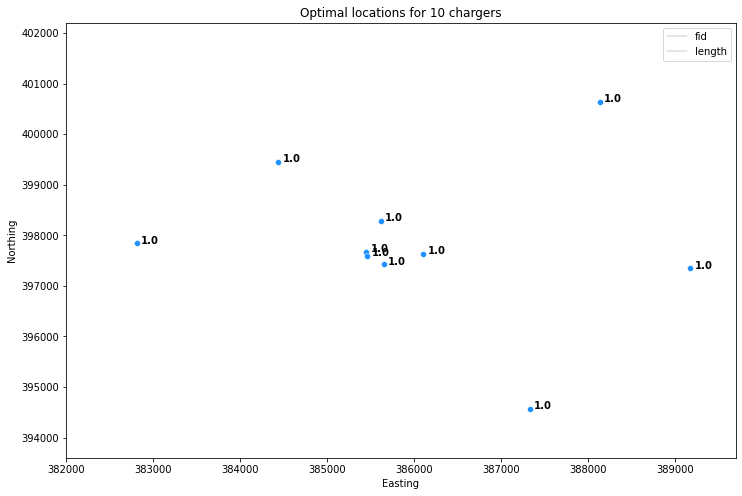

([0, 32, 65, 67, 69, 70, 76, 90, 91, 99],     status  Tot_no_chargers
 0  Optimal               10)

In [85]:
optimize(GIS_df,car_park_df)